In [23]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
import matplotlib.patches as patches
import scipy.io


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import imputation
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot
import spectral

In [2]:
assembly = pcu.loadAssembly("GRCm39_Assembly.txt")

chromDict = dict(zip(assembly['RefSeq accession'],assembly['Chromosome'].apply(lambda x : f"chr{x}")))

# the reverse for easy lookup
chromDict_r = {v: k for k, v in chromDict.items()}

chromOrder = list(chromDict.values())

In [3]:
# # load the filtered pore-C data
# dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
# cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
# filetags = [f"run0{x}" for x in cellNums]

# # filetags = [f"run0{x}" for x in range(1, 2)]

# assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
# rawCells = pcu.loadRawContactDirectory(dirpath, filetags)

# print("Filtering....")
# filteredCells = filters.runAllFilters(rawCells,
#                               assembly,
#                               adjacent=False,
#                               chromosome=None, 
#                               verbose=False)  

# print(f"\n{filteredCells.keys()=}")



In [4]:
# filepath = "filtered_data/clique1MBfiltered.csv"
filepath = "filtered_data/adjacent1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")

filteredCells = {}

for runId in df['cell'].unique():
    tmp = df[df['cell'] == runId]
    filteredCells[runId] = tmp.reset_index(drop=True)
    

print(f"\n{filteredCells.keys()=}")

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39,45) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(286943, 66)

filteredCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [5]:
resolution = 100000 # 100kb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'

binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{runId=} {A.shape=}")
    matrices[runId] = A
    
print(f"{matrices.keys()}")

runId='run01' A.shape=(27235, 27235)
runId='run02' A.shape=(27235, 27235)
runId='run04' A.shape=(27235, 27235)
runId='run05' A.shape=(27235, 27235)
runId='run06' A.shape=(27235, 27235)
runId='run07' A.shape=(27235, 27235)
dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [6]:
newRows = []

for idx, row in assembly.iterrows():
    if "NC" in row['RefSeq accession']:
        
        start = binning.returnBin(row['chromStart'], bins) + 2
        end = binning.returnBin(row['chromEnd'], bins) + 3
        
        newRow = {
            'region' : f"chr{row['Chromosome']}",
            'start' : start,
            'end' : end,
            'length' : end - start,
        }
        
        newRows.append(newRow)
        
filteredChromInfo = pd.DataFrame(newRows)

filteredPoreCIndex = list(range(0, len(A)))
print(f"{len(filteredPoreCIndex)=}")

len(filteredPoreCIndex)=27235


In [7]:
chromosome = ['chr2']
chrPorecInd = pcu.getIndices(filteredChromInfo, filteredPoreCIndex, chromosome, 'region')

matricesChr2 = {}

for runId, mat in matrices.items():    
    A = mat[chrPorecInd, :][:, chrPorecInd]
    
    print(f"{runId=} {A.shape=}")
    matricesChr2[runId] = A
    
matricesChr2.keys()

runId='run01' A.shape=(1819, 1819)
runId='run02' A.shape=(1819, 1819)
runId='run04' A.shape=(1819, 1819)
runId='run05' A.shape=(1819, 1819)
runId='run06' A.shape=(1819, 1819)
runId='run07' A.shape=(1819, 1819)


dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])

# Load TAD Boundaries

In [8]:
tad = pd.read_csv('F121_mESC_TADS.txt', sep='\t', header=None)
tad.columns = ['id', 'start', 'end', 'undef']
tad['phase'] = tad['id'].apply( lambda x: x.split("_")[0])
tad['chrom'] = tad['id'].apply( lambda x: x.split("_")[1])

print(f"{tad.shape=}")

tadChr2 = tad[(tad['chrom'] == '2') & (tad['phase'] == 'G1')].reset_index(drop=True)
print(f"{tadChr2.shape=}")
tadChr2.head()

tad.shape=(4104, 6)
tadChr2.shape=(160, 6)


,id,start,end,undef,phase,chrom
0,G1_2,154413264,154595264,20,G1,2
1,G1_2,152671264,153584264,20,G1,2
2,G1_2,156370264,157570264,20,G1,2
3,G1_2,30076480,30354480,20,G1,2
4,G1_2,164950500,165729500,20,G1,2


In [9]:

binStart = []
binEnd = []

for idx, row in tadChr2.iterrows():
    tadStart = binning.returnBin(row['start'], bins)
    tadEnd = binning.returnBin(row['end'], bins)
    
    binStart.append(tadStart)
    binEnd.append(tadEnd)
    
tadChr2['binStart'] = binStart
tadChr2['binEnd'] = binEnd
tadChr2['tadLen'] = tadChr2['binEnd'] - tadChr2['binStart']

tadChr2.head()

,id,start,end,undef,phase,chrom,binStart,binEnd,tadLen
0,G1_2,154413264,154595264,20,G1,2,1543,1544,1
1,G1_2,152671264,153584264,20,G1,2,1525,1534,9
2,G1_2,156370264,157570264,20,G1,2,1562,1574,12
3,G1_2,30076480,30354480,20,G1,2,299,302,3
4,G1_2,164950500,165729500,20,G1,2,1648,1656,8


In [10]:
print(f"{tadChr2['binStart'].min()=}")
print(f"{tadChr2['binStart'].max()=}")

tadChr2['binStart'].min()=30
tadChr2['binStart'].max()=1734


<ipython-input-11-ab4b3c70e1ce>:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '3Mb'])
<ipython-input-11-ab4b3c70e1ce>:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


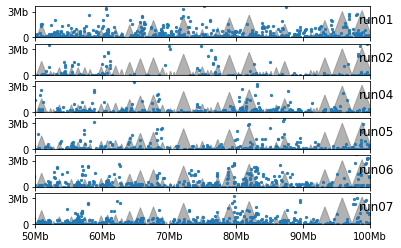

In [11]:
def matrix2XY(A):
    """A function to convert a contact matrix to x, y coords """
    x, y = np.nonzero(np.tril(A))
    y = np.abs(y - x)
    return x, y

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 20, 6

fig, axs = plt.subplots(6, sharex=True)

plotNum = 0
for runId, A in matricesChr2.items(): 

    ax = axs[plotNum]
    plotNum += 1
    
    x, y = matrix2XY(A)

    ax.scatter(x, y, marker='.', s=20, alpha=0.9)
    
    ax.set_ylim(0, 30)
    ax.set_xlim(500, 1000)
    
    for idx, row in tadChr2.iterrows():
        
        height = row['tadLen'] * np.sqrt(3) / 2
        midPoint = row['binStart'] + row['tadLen'] / 2
        
        tadCoords = np.array([[row['binStart'], 0],
                             [midPoint, height],
                             [row['binEnd'], 0]])
        
        tadShape = plt.Polygon(tadCoords, 
                               facecolor='grey', 
                               edgecolor='grey',
                               alpha=0.6,
                               zorder=0)
        ax.add_patch(tadShape)
    
    ax.set_title(f'{runId}', rotation=0, x=1.02, y=0.25)
    ax.set_yticklabels(['0', '3Mb'])
    n = len(ax.get_xticklabels())
    xlim = ax.axes.get_xlim()
    newLabels = np.linspace(xlim[0], xlim[1], n)
    newLabels = [f"{int(x/10)}Mb" for x in newLabels]
    ax.set_xticklabels(newLabels)
    
# plt.tight_layout()

In [12]:
def mb2kb(mb):
    return 1000 * mb

def kb2mb(kb):
    return 0.001 * kb


<ipython-input-13-37f859776416>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '3Mb'])
<ipython-input-13-37f859776416>:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(newLabels)


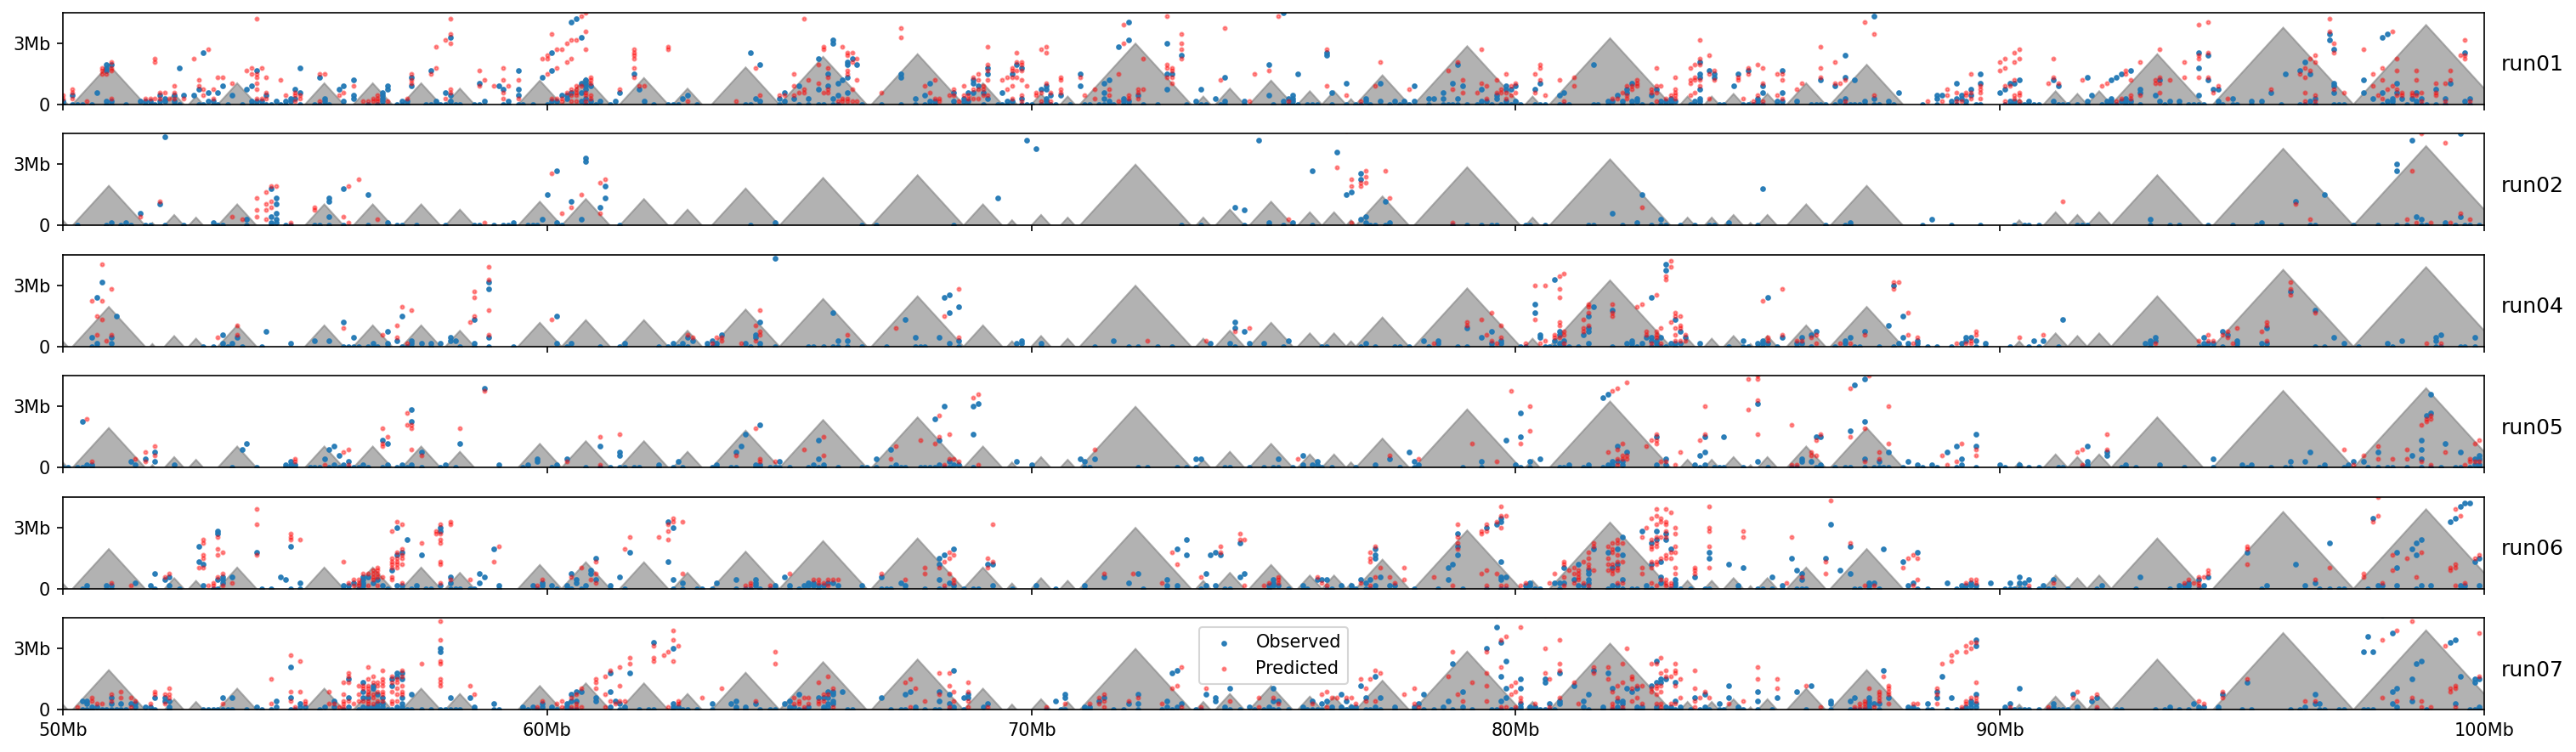

In [13]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = 20, 6

fig, axs = plt.subplots(6, sharex=True)
tau = 0.7

plotNum = 0
for runId, A in matricesChr2.items(): 

    ax = axs[plotNum]
    plotNum += 1
    
    Ahat, scores = imputation.imputeEdges(A, tau, method=4, return_scores=True) 
    imputedEdges = np.where(scores >= tau, 1, 0)
    
    x, y = matrix2XY(A)
    xHat, yHat = matrix2XY(imputedEdges)
    
    ax.scatter(x, y, marker='.', s=20, alpha=0.9, label='Observed')
    ax.scatter(xHat, yHat, marker='.', c='r', s=15, alpha=0.4, label='Predicted')
    
    
    ax.set_ylim(0, 30)
    ax.set_xlim(500, 1000)
    
    for idx, row in tadChr2.iterrows():
        
        height = row['tadLen'] * np.sqrt(3) / 2
        midPoint = row['binStart'] + row['tadLen'] / 2
        
        tadCoords = np.array([[row['binStart'], 0],
                             [midPoint, height],
                             [row['binEnd'], 0]])
        
        tadShape = plt.Polygon(tadCoords, 
                               facecolor='grey', 
                               edgecolor='grey',
                               alpha=0.6,
                               zorder=0)
        ax.add_patch(tadShape)
    
    ax.set_title(f'{runId}', rotation=0, x=1.02, y=0.25)
    ax.set_yticklabels(['0', '3Mb'])
    n = len(ax.get_xticklabels())
    xlim = ax.axes.get_xlim()
    newLabels = np.linspace(xlim[0], xlim[1], n)
    newLabels = [f"{int(x/10)}Mb" for x in newLabels]
    ax.set_xticklabels(newLabels)
    
plt.tight_layout()
plt.legend()

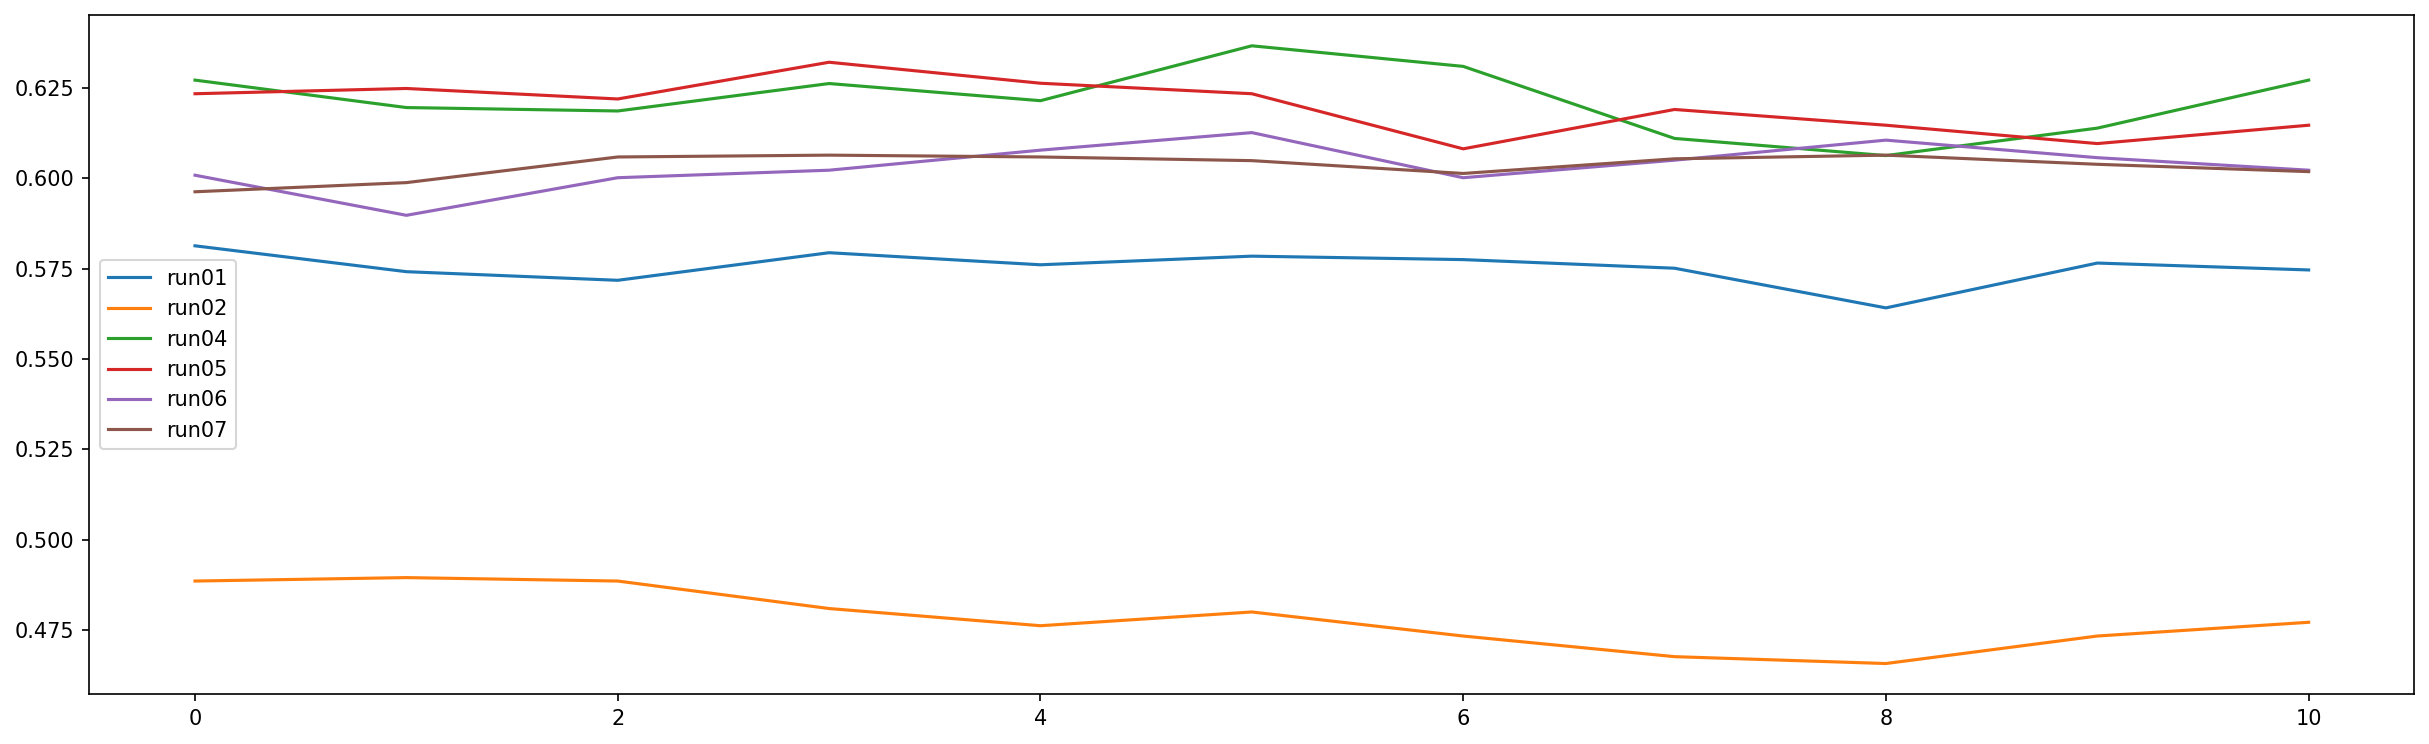

In [44]:
def getTADProportion(A, tad):
    """A function to return the ratio of contacts with
    TAD boundaries/outside TAD boundaries within some threshold
    from the diagional """
    
    tadSum = 0
    totalSum = A.sum()
    
    for idx, row in tad.iterrows():
        
        binStart = row['binStart']
        binEnd = row['binEnd']
        tadLen =  row['tadLen']
        tadRegion = A[binStart:binEnd, binStart:binEnd]
        tadSum += tadRegion.sum()
        
    tadScore = tadSum / totalSum
    return tadScore
    

newRows = []
for runId, A in matricesChr2.items(): 
    
    for offset in np.linspace(0, 10, 11):
        
        tadTmp = tadChr2.copy()
        
        tadTmp['binStart'] = tadTmp['binStart'] + int(offset)
        tadTmp['binEnd'] = tadTmp['binEnd'] + int(offset)
        
        tadScore = getTADProportion(A, tadTmp)
        
        row = {
            'cell' : runId,
            'nContacts' : np.triu(A).sum(),
            'offset' : offset,
            'tadScore' : tadScore,
            
        }
        
        newRows.append(row)
    
results = pd.DataFrame(newRows)


for runId in results['cell'].unique():
    
    cell = results[results['cell'] == runId]
    
    plt.plot(cell['offset'], cell['tadScore'], label=f"{runId}")

    
plt.legend()